In [1]:
%pip install -q --upgrade keras keras-cv tensorflow tensorflow_datasets setuptools scikit-learn segmentation-models matplotlib opencv-python seaborn keras_tuner pandas
print("Successfully installed required packages.")


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install kaggle
# !kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
!unzip chest-xray-masks-and-labels.zip
# !unzip tuberculosis-tb-chest-xray-dataset.zip
# !rm -rf data
!mv Lung\ Segmentation segmentation_data
!rm -rf ./segmentation_data/ClinicalReadings
!rm -rf ./data
!rm ./segmentation_data/NLM-ChinaCXRSet-ReadMe.docx
!rm ./segmentation_data/NLM-MontgomeryCXRSet-ReadMe.pdf
!mv ./segmentation_data/CXR_png ./segmentation_data/images
# !mv TB_Chest_Radiography_Database data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.8/162.8 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 26.0 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=ac986b461f5a3102f29492692433900c4e55512642eba377bb910d3ed719430e
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Dataset URL: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 9.57G/9.58G [06:22<00:00, 32.9MB/s]
100%|██████████████████████████████████████| 9.58G/9.58G 

In [3]:
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                    
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf fontconfig fontconfig-config
  fonts-dejavu-core i965-va-driver intel-media-va-driver libaacs0 libaom3
  libasound2 libasound2-data libass9 libasyncns0 libavc1394-0 libavcodec58
  libavdevice58 libavfilter7 libavformat58 libavutil56 libbdplus0 libblas3
  libbluray2 libbs2b0 libcaca0 libcairo-gobject2 libcairo2 libcdio-cdda2
  libcdio-paranoia2 libcdio19 libchromaprint1 libcodec2-1.0 libdatrie1
  libdav1d5 libdc1394-25 lib

In [217]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import keras
import keras_tuner
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2

In [2]:
DATA_DIR = "./segmentation_data"
image_dir = os.path.join(DATA_DIR, "images")
mask_dir = os.path.join(DATA_DIR, "masks")

masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]
for mask in masks:
    if mask.endswith("_mask.png"):
        os.rename(os.path.join(mask_dir, mask), os.path.join(mask_dir, mask.replace("_mask", "")))

images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
for img in images:
    if os.path.isfile(os.path.join(mask_dir, img)):
        continue
    os.remove(os.path.join(image_dir, img))

# Split the dataset into training and validation sets
images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.1)

if os.path.exists(os.path.join(DATA_DIR, "train")):
    print("Removing existing train dataset...")
    shutil.rmtree(os.path.join(DATA_DIR, "train"))

if os.path.exists(os.path.join(DATA_DIR, "val")):
    print("Removing existing validation dataset...")
    shutil.rmtree(os.path.join(DATA_DIR, "val"))

train_image_dir = os.path.join(DATA_DIR, "train", "images")
val_image_dir = os.path.join(DATA_DIR, "val", "images")
train_mask_dir = os.path.join(DATA_DIR, "train", "masks")
val_mask_dir = os.path.join(DATA_DIR, "val", "masks")

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

def copy_files(file_list, src_dir, dst_dir):
    for file in file_list:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

print("Copying train images...")
copy_files(train_images, image_dir, train_image_dir)
print("Copying validation images...")
copy_files(val_images, image_dir, val_image_dir)
print("Copying train masks...")
copy_files(train_masks, mask_dir, train_mask_dir)
print("Copying validation masks...")
copy_files(val_masks, mask_dir, val_mask_dir)

Removing existing train dataset...
Removing existing validation dataset...
Copying train images...
Copying validation images...
Copying train masks...
Copying validation masks...


In [187]:
# https://www.tensorflow.org/tutorials/images/segmentation
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()

        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = keras.Sequential([
            keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed),
            keras.layers.RandomBrightness(factor=0.2, value_range=(0, 255), seed=seed),
            keras.layers.RandomRotation(factor=0.2, seed=seed)
        ])
        self.augment_labels = keras.Sequential([
            keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed),
            keras.layers.RandomRotation(factor=0.2, seed=seed)
        ])

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)

        return inputs, labels / 255

def augment_validation(inputs, labels):
    return inputs, labels / 255

def get_data(batch_size, image_size=(256, 256), masks_size=(256, 256)):
    train_images, validation_images = keras.utils.image_dataset_from_directory(
        "segmentation_data/train/images",
        labels=None,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=False,
        validation_split=0.1,
        subset='both'
    )

    train_masks, validation_masks = keras.utils.image_dataset_from_directory(
        "segmentation_data/train/masks",
        labels=None,
        batch_size=batch_size,
        image_size=masks_size,
        color_mode='grayscale',
        shuffle=False,
        validation_split=0.1,
        subset='both'
    )

    training_dataset = tf.data.Dataset.zip(train_images, train_masks)
    validation_dataset = tf.data.Dataset.zip(validation_images, validation_masks)

    training_dataset = training_dataset.map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(augment_validation).prefetch(buffer_size=tf.data.AUTOTUNE)

    return training_dataset, validation_dataset

## Resnet34

In [10]:
BACKBONE = 'resnet34'
def build_resnet_model(hp):
    loss_idx = hp.Choice('loss_idx', values=[0, 1])
    losses = [keras.losses.binary_crossentropy, sm.losses.dice_loss]
    loss = losses[loss_idx]

    optimizer_idx = hp.Choice('optimizer_idx', values=[0, 1])
    optimizers = [keras.optimizers.Adam(), keras.optimizers.SGD()]
    optimizer = optimizers[optimizer_idx]

    model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', sm.metrics.IOUScore(), sm.metrics.FScore()]
    )

    return model

In [12]:
preprocess_input = sm.get_preprocessing(BACKBONE)

def process_dataset(images, labels):
    return preprocess_input(images), labels

for batch_size in [4, 8, 16]:
    project_name= 'resnet34-%d' % batch_size

    training_dataset, validation_dataset = get_data(batch_size)
    training_dataset = training_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)

    tuner = keras_tuner.GridSearch(
        objective='val_loss',
        hypermodel=build_resnet_model,
        project_name=project_name
    )

    tensorboard_cb = keras.callbacks.TensorBoard(log_dir='tensorboard/%s' % (project_name))
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=10)
    reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(patience=5, cooldown=5)

    tuner.search(
        training_dataset,
        batch_size=batch_size,
        epochs=50,
        validation_data=validation_dataset,
        callbacks=[tensorboard_cb, early_stopping_cb, reduce_lr_cb]
    )

Trial 4 Complete [00h 12m 00s]
val_loss: 0.20852604508399963

Best val_loss So Far: 0.17512701451778412
Total elapsed time: 00h 32m 36s


## Inceptionv3

In [176]:
BACKBONE = 'inceptionv3'
def build_inceptionv3_model(hp):
    loss_idx = hp.Choice('loss_idx', values=[0, 1])
    losses = [keras.losses.binary_crossentropy, sm.losses.dice_loss]
    loss = losses[loss_idx]

    optimizer_idx = hp.Choice('optimizer_idx', values=[0, 1])
    optimizers = [keras.optimizers.Adam(), keras.optimizers.SGD()]
    optimizer = optimizers[optimizer_idx]

    model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', sm.metrics.IOUScore(), sm.metrics.FScore()]
    )

    return model

In [177]:
preprocess_input = sm.get_preprocessing(BACKBONE)

def process_dataset(images, labels):
    return preprocess_input(images), labels

for batch_size in [4, 8, 16]:
    project_name = 'inceptionv3-%d' % batch_size

    training_dataset, validation_dataset = get_data(batch_size)
    training_dataset = training_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)

    tuner = keras_tuner.GridSearch(
        objective='val_loss',
        hypermodel=build_inceptionv3_model,
        project_name=project_name
    )

    tensorboard_cb = keras.callbacks.TensorBoard(log_dir='tensorboard/%s' % (project_name))
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=10)
    reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(patience=5, cooldown=5)

    tuner.search(
        training_dataset,
        batch_size=batch_size,
        epochs=50,
        validation_data=validation_dataset,
        callbacks=[tensorboard_cb, early_stopping_cb, reduce_lr_cb]
    )

Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Reloading Tuner from ./inceptionv3-4/tuner0.json
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Reloading Tuner from ./inceptionv3-8/tuner0.json
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Reloading Tuner from ./inceptionv3-16/tuner0.json


## Original Model

In [21]:
def conv_block(inputs, num_filters):
    x = keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = keras.layers.MaxPool2D((2, 2))(x)

    return x, p

def decoder_block(inputs, skip, num_filters):
    x = keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = keras.layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)

    return x

def build_unet(input_shape=(256, 256, 3)):
    inputs = keras.Input(shape=input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    dropout = keras.layers.Dropout(0.2)(d4)
    outputs = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(dropout)

    return keras.Model(inputs, outputs, name='U-Net')

def build_original_model(hp):
    loss_idx = hp.Choice('loss_idx', values=[0, 1, 2, 3])
    losses = [sm.losses.bce_jaccard_loss, sm.losses.jaccard_loss, sm.losses.bce_dice_loss, sm.losses.dice_loss]
    loss = losses[loss_idx]

    optimizer_idx = hp.Choice('optimizer_idx', values=[0])
    optimizers = [keras.optimizers.Adam()]
    optimizer = optimizers[optimizer_idx]

    model = build_unet()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', sm.metrics.IOUScore(), sm.metrics.FScore()]
    )

    return model

In [66]:
def preprocess_input(images):
    return images / 255

def process_dataset(images, labels):
    return preprocess_input(images), labels

for batch_size in [4, 8, 16]:
    project_name = 'original-%d' % batch_size

    training_dataset, validation_dataset = get_data(batch_size)
    training_dataset = training_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)

    tuner = keras_tuner.GridSearch(
        objective='val_loss',
        hypermodel=build_original_model,
        project_name=project_name
    )

    tensorboard_cb = keras.callbacks.TensorBoard(log_dir='tensorboard/%s' % (project_name))
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=10)
    reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(patience=5, cooldown=5)

    tuner.search(
        training_dataset,
        batch_size=batch_size,
        epochs=50,
        validation_data=validation_dataset,
        callbacks=[tensorboard_cb, early_stopping_cb, reduce_lr_cb]
    )

Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Found 633 files.
Using 570 files for training.
Using 63 files for validation.


Reloading Tuner from ./original-4/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
2                 |1                 |loss_idx
0                 |0                 |optimizer_idx

Epoch 1/50


I0000 00:00:1724318708.688432    3718 service.cc:146] XLA service 0x7f8b580032d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724318708.688479    3718 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-22 09:25:08.839547: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-22 09:25:09.431023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


## Actual Original?

In [4]:
def build_unet(input_shape=(572, 572, 1)):
    inputs = keras.layers.Input(shape=input_shape)
    encoder = keras.layers.BatchNormalization()(inputs)

    encoder = keras.layers.Conv2D(64, 3, activation='relu')(inputs)
    encoder = keras.layers.BatchNormalization()(encoder)
    encoder = keras.layers.Conv2D(64, 3, activation='relu')(encoder)
    encoder = keras.layers.BatchNormalization()(encoder)
    pool1 = keras.layers.MaxPool2D((2, 2))(encoder)

    encoder = keras.layers.Conv2D(128, 3, activation='relu')(pool1)
    encoder = keras.layers.BatchNormalization()(encoder)
    encoder = keras.layers.Conv2D(128, 3, activation='relu')(encoder)
    encoder = keras.layers.BatchNormalization()(encoder)
    pool2 = keras.layers.MaxPool2D((2, 2))(encoder)

    encoder = keras.layers.Conv2D(256, 3, activation='relu')(pool2)
    encoder = keras.layers.BatchNormalization()(encoder)
    encoder = keras.layers.Conv2D(256, 3, activation='relu')(encoder)
    encoder = keras.layers.BatchNormalization()(encoder)
    pool3 = keras.layers.MaxPool2D((2, 2))(encoder)

    encoder = keras.layers.Conv2D(512, 3, activation='relu')(pool3)
    encoder = keras.layers.BatchNormalization()(encoder)
    encoder = keras.layers.Conv2D(512, 3, activation='relu')(encoder)
    encoder = keras.layers.BatchNormalization()(encoder)
    pool4 = keras.layers.MaxPool2D((2, 2))(encoder)

    bridge = keras.layers.Conv2D(1024, 3, activation='relu')(pool4)
    bridge = keras.layers.BatchNormalization()(bridge)
    bridge = keras.layers.Conv2D(1024, 3, activation='relu')(bridge)
    bridge = keras.layers.BatchNormalization()(bridge)

    decoder = keras.layers.Conv2DTranspose(1024, (2, 2), strides=2, padding='same')(bridge)
    decoder = keras.layers.Concatenate()([decoder, keras.layers.CenterCrop(56, 56)(pool4)])
    decoder = keras.layers.Conv2D(512, 3, activation='relu')(decoder)
    decoder = keras.layers.BatchNormalization()(decoder)
    decoder = keras.layers.Conv2D(512, 3, activation='relu')(decoder)
    decoder = keras.layers.BatchNormalization()(decoder)

    decoder = keras.layers.Conv2DTranspose(512, (2, 2), strides=2, padding='same')(decoder)
    decoder = keras.layers.Concatenate()([decoder, keras.layers.CenterCrop(104, 104)(pool3)])
    decoder = keras.layers.Conv2D(256, 3, activation='relu')(decoder)
    decoder = keras.layers.BatchNormalization()(decoder)
    decoder = keras.layers.Conv2D(256, 3, activation='relu')(decoder)
    decoder = keras.layers.BatchNormalization()(decoder)

    decoder = keras.layers.Conv2DTranspose(256, (2, 2), strides=2, padding='same')(decoder)
    decoder = keras.layers.Concatenate()([decoder, keras.layers.CenterCrop(200, 200)(pool2)])
    decoder = keras.layers.Conv2D(128, 3, activation='relu')(decoder)
    decoder = keras.layers.BatchNormalization()(decoder)
    decoder = keras.layers.Conv2D(128, 3, activation='relu')(decoder)
    decoder = keras.layers.BatchNormalization()(decoder)

    decoder = keras.layers.Conv2DTranspose(128, (2, 2), strides=2, padding='same')(decoder)
    decoder = keras.layers.Concatenate()([decoder, keras.layers.CenterCrop(392, 392)(pool1)])
    decoder = keras.layers.Conv2D(64, 3, activation='relu')(decoder)
    decoder = keras.layers.BatchNormalization()(decoder)
    decoder = keras.layers.Conv2D(64, 3, activation='relu')(decoder)
    decoder = keras.layers.BatchNormalization()(decoder)

    decoder = keras.layers.Conv2D(2, 3, activation='relu', padding='same')(decoder)

    outputs = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(decoder)

    return keras.Model(inputs, outputs, name='U-Net')

def build_original_model(hp):
    loss_idx = hp.Choice('loss_idx', values=[0, 1, 2])
    losses = [sm.losses.dice_loss, sm.losses.jaccard_loss]
    loss = losses[loss_idx]

    optimizer_idx = hp.Choice('optimizer_idx', values=[0])
    optimizers = [keras.optimizers.Adam()]
    optimizer = optimizers[optimizer_idx]

    model = build_unet()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', sm.metrics.IOUScore(), sm.metrics.FScore()]
    )

    return model

In [5]:
for batch_size in [16, 32]:
    project_name = 'original-%d' % batch_size

    training_dataset, validation_dataset = get_data(batch_size, image_size=(572, 572), masks_size=(388, 388), color_mode='grayscale')

    tuner = keras_tuner.GridSearch(
        objective='val_loss',
        hypermodel=build_original_model,
        project_name=project_name
    )

    tensorboard_cb = keras.callbacks.TensorBoard(log_dir='tensorboard/%s' % (project_name))
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=10)
    reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(patience=5, cooldown=5)

    tuner.search(
        training_dataset,
        batch_size=batch_size,
        epochs=50,
        validation_data=validation_dataset,
        callbacks=[tensorboard_cb, early_stopping_cb, reduce_lr_cb]
    )

Found 633 files.
Using 570 files for training.
Using 63 files for validation.


Found 633 files.
Using 570 files for training.
Using 63 files for validation.


2024-08-22 12:31:20.293032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22456 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:06:00.0, compute capability: 8.6



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0                 |0                 |loss_idx
0                 |0                 |optimizer_idx

Epoch 1/50


I0000 00:00:1724329892.268002   70182 service.cc:146] XLA service 0x7fe84c043750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724329892.268034   70182 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-22 12:31:32.903914: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-22 12:31:33.817272: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-08-22 12:31:58.977779: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,192,392,392]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,390,390]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.7841 - f1-score: 0.6130 - iou_score: 0.4544 - loss: 0.3870

2024-08-22 12:34:08.574531: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-22 12:34:10.755960: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-22 12:34:16.287736: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


36/36 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.7871 - f1-score: 0.6171 - iou_score: 0.4589 - loss: 0.3827 - val_accuracy: 0.7884 - val_f1-score: 0.3464 - val_iou_score: 0.2106 - val_loss: 0.6532 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 755ms/step - accuracy: 0.8755 - f1-score: 0.7379 - iou_score: 0.5878 - loss: 0.2619 - val_accuracy: 0.7871 - val_f1-score: 0.2570 - val_iou_score: 0.1476 - val_loss: 0.7427 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 756ms/step - accuracy: 0.8707 - f1-score: 0.7265 - iou_score: 0.5737 - loss: 0.2734 - val_accuracy: 0.7754 - val_f1-score: 0.0416 - val_iou_score: 0.0212 - val_loss: 0.9584 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 761ms/step - accuracy: 0.8892 - f1-score: 0.7603 - iou_score: 0.6172 - loss: 0.2396 - val_accuracy: 0.7763 - val_f1-score: 0.0309 - val_iou_score: 0.0157 - val_loss: 0.9691 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 766ms/step - ac

## XCeption Style

In [183]:
# TODO:: CITE
def build_xception(img_size, dropout_rate=0.0):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    dropout = keras.layers.Dropout(dropout_rate)(x)
    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same")(dropout)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


def build_xception_model(hp):
    loss_idx = hp.Choice('loss_idx', values=[0, 1])
    losses = [keras.losses.binary_crossentropy, sm.losses.dice_loss]
    loss = losses[loss_idx]

    optimizer_idx = hp.Choice('optimizer_idx', values=[0, 1])
    optimizers = [keras.optimizers.Adam(), keras.optimizers.SGD()]
    optimizer = optimizers[optimizer_idx]

    model = build_xception((256, 256))

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', sm.metrics.IOUScore(), sm.metrics.FScore()]
    )

    return model

In [179]:
def preprocess_input(images):
    return images / 255

def process_dataset(images, labels):
    return preprocess_input(images), labels

for batch_size in [4, 8, 16]:
    project_name = 'xception-%d' % batch_size

    training_dataset, validation_dataset = get_data(batch_size)
    training_dataset = training_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)

    tuner = keras_tuner.GridSearch(
        objective='val_loss',
        hypermodel=build_xception_model,
        project_name=project_name
    )

    tensorboard_cb = keras.callbacks.TensorBoard(log_dir='tensorboard/%s' % (project_name))
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(patience=5, cooldown=5)

    tuner.search(
        training_dataset,
        batch_size=batch_size,
        epochs=50,
        validation_data=validation_dataset,
        callbacks=[tensorboard_cb, early_stopping_cb, reduce_lr_cb]
    )

Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Reloading Tuner from ./xception-4/tuner0.json
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Reloading Tuner from ./xception-8/tuner0.json
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Found 633 files.
Using 570 files for training.
Using 63 files for validation.
Reloading Tuner from ./xception-16/tuner0.json


## Fine tuning xception

In [188]:
project_name = 'xception-%s' % 'fine-tuning'

def build_xception_fine_tuning(hp):
    dropout = hp.Choice('dropout', values=[0.0, 0.4, 0.6])
    model = build_xception((256, 256), dropout)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=sm.losses.dice_loss,
        metrics=['accuracy', sm.metrics.IOUScore(), sm.metrics.FScore()]
    )

    return model

training_dataset, validation_dataset = get_data(4)
training_dataset = training_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)

tuner = keras_tuner.GridSearch(
    objective='val_loss',
    hypermodel=build_xception_fine_tuning,
    project_name=project_name
)

tensorboard_cb = keras.callbacks.TensorBoard(log_dir='tensorboard/%s' % (project_name))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(patience=5, cooldown=5)

tuner.search(
    training_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[tensorboard_cb, early_stopping_cb, reduce_lr_cb]
)

Trial 3 Complete [00h 22m 33s]
val_loss: 0.04495871812105179

Best val_loss So Far: 0.043381430208683014
Total elapsed time: 00h 56m 23s


Found 71 files.
Found 71 files.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


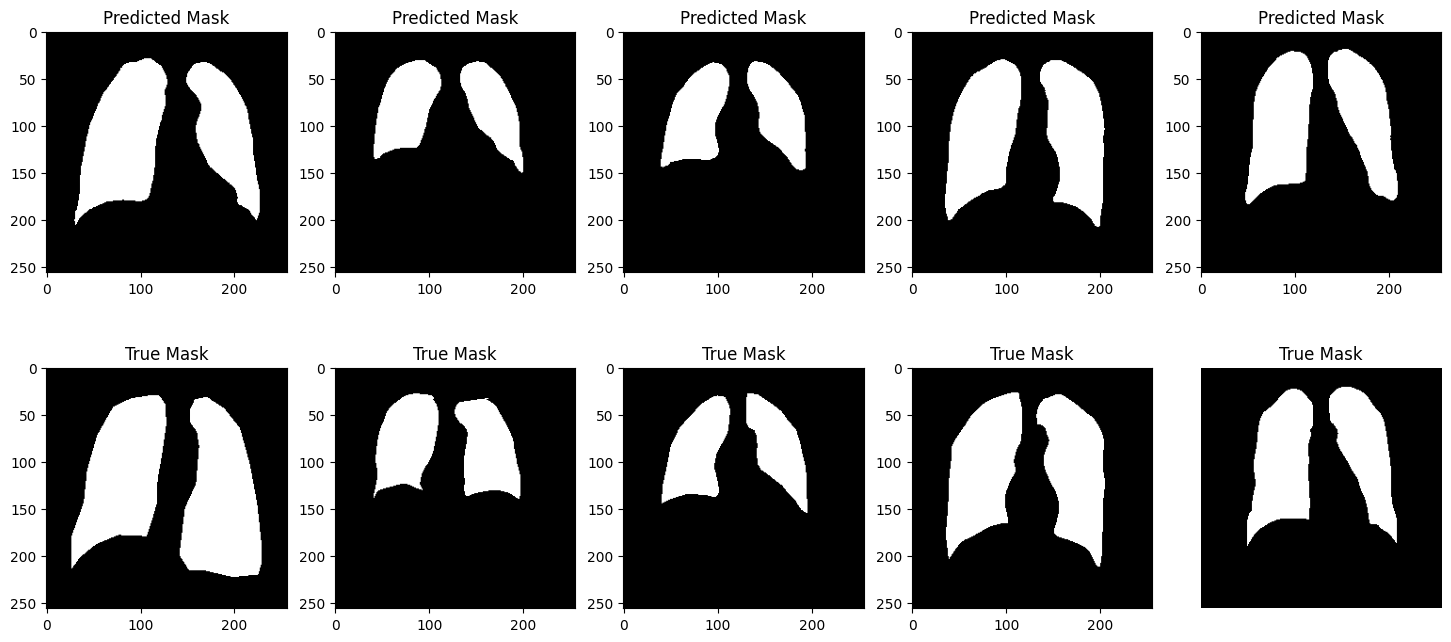

In [222]:
test_images = keras.utils.image_dataset_from_directory(
    "segmentation_data/val/images",
    labels=None,
    batch_size=4,
    image_size=(256, 256),
    shuffle=False
)

test_masks = keras.utils.image_dataset_from_directory(
    "segmentation_data/val/masks",
    labels=None,
    batch_size=4,
    image_size=(256, 256),
    color_mode='grayscale',
    shuffle=False
)

test_dataset = tf.data.Dataset.zip(test_images, test_masks)
test_dataset = test_dataset.map(augment_validation).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)

model = tuner.get_best_models()[0]

test_dataset_iterator = list(test_dataset.take(5).as_numpy_iterator())

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(18, 8))
for i, (image, mask) in enumerate(test_dataset_iterator):
    true_y = mask[0].astype(np.uint8)
    im = image[0].astype(np.uint8)
    pred = model.predict(image)
    pred = (pred[0] > 0.5).astype(np.uint8)

    ax[0, i].imshow(pred, cmap='gray')
    ax[0, i].set_title('Predicted Mask')

    ax[1, i].imshow(true_y, cmap='gray')
    ax[1, i].set_title('True Mask')

plt.axis('off')
plt.show()

## EfficientNetB5

In [8]:
BACKBONE = 'efficientnetb5'
def build_efficientnet_model(hp):
    loss_idx = hp.Choice('loss_idx', values=[0, 1])
    losses = [keras.losses.binary_crossentropy, sm.losses.dice_loss]
    loss = losses[loss_idx]

    optimizer_idx = hp.Choice('optimizer_idx', values=[0, 1])
    optimizers = [keras.optimizers.Adam(), keras.optimizers.SGD()]
    optimizer = optimizers[optimizer_idx]

    model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', sm.metrics.IOUScore(), sm.metrics.FScore()]
    )

    return model

In [10]:
from keras.applications.efficientnet_v2 import preprocess_input

# preprocess_input = sm.get_preprocessing(BACKBONE)

def process_dataset(images, labels):
    return preprocess_input(images), labels

for batch_size in [4, 8, 16]:
    project_name = 'efficientnetb5-%d' % batch_size

    training_dataset, validation_dataset = get_data(batch_size)
    training_dataset = training_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(process_dataset).prefetch(buffer_size=tf.data.AUTOTUNE)

    tuner = keras_tuner.GridSearch(
        objective='val_loss',
        hypermodel=build_efficientnet_model,
        project_name=project_name
    )

    tensorboard_cb = keras.callbacks.TensorBoard(log_dir='tensorboard/%s' % (project_name))
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=10)
    reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(patience=5, cooldown=5)

    tuner.search(
        training_dataset,
        batch_size=batch_size,
        epochs=50,
        validation_data=validation_dataset,
        callbacks=[tensorboard_cb, early_stopping_cb, reduce_lr_cb]
    )

Trial 4 Complete [00h 10m 54s]
val_loss: 0.19074589014053345

Best val_loss So Far: 0.17619381844997406
Total elapsed time: 00h 39m 21s
